### Import necessary packages

In [1]:
import pandas as pd
import pandas_datareader as web
import datetime
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Functions to import price data

In [2]:
def read_price_data(stock_symbol, start_date, end_date, interval):
    """Import price data from Yahoo Finance"""
    try:
        stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    except:
        return None

    prices = stock_data.loc[:, "Adj Close"] # adjusted for stock splits and dividends
    prices = prices.fillna(method="ffill")

    return prices

In [3]:
def get_date_list(stock_symbol, start_date, end_date, interval):
    """Generate list of trading dates"""
    stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    dates = stock_data.index
    
    return dates

### Generate input table for month on month comparison of a stock against S&P 500

In [4]:
tesla = "TSLA" # <-- Please enter Stock symbol
ford = "FORD" # <-- Please enter Stock symbol

# Generate list of trading days
start_date = datetime.datetime(2020, 9, 25)
end_date = datetime.datetime(2022, 9, 25)
interval = 'd' 
date_list = get_date_list(tesla, start_date, end_date, interval=interval)

# Generate empty dataframe
df_tesla = pd.DataFrame(columns=['Return of Tesla on day t, %', 'Return of Tesla on day t+1, %'], index=date_list)
df_ford = pd.DataFrame(columns=['Return of Ford on day t, %', 'Return of Ford on day t+1, %'], index=date_list)

# Sort dataframe based on date
df_tesla = df_tesla.sort_index(ascending=False)  
df_ford = df_ford.sort_index(ascending=False)

# Import price series into dataframe
try:    
    price_series = read_price_data(tesla, start_date, end_date, interval=interval)
    df_tesla['Return of Tesla on day t, %'] = price_series  
    
    price_series = read_price_data(ford, start_date, end_date, interval=interval)
    df_ford['Return of Ford on day t, %'] = price_series  
     
except:
    print('Import failed')

# Fill in prices for t+1 column
df_tesla['Return of Tesla on day t+1, %'] = df_tesla['Return of Tesla on day t, %'].shift(1)
df_ford['Return of Ford on day t+1, %'] = df_ford['Return of Ford on day t, %'].shift(1)
df_tesla = df_tesla.dropna()
df_ford = df_ford.dropna()
df_tesla.head()
df_ford.head()

,"Return of Tesla on day t, %","Return of Tesla on day t+1, %"
Date,,
2022-09-22,288.589996,275.329987
2022-09-21,300.799988,288.589996
2022-09-20,308.730011,300.799988
2022-09-19,309.070007,308.730011
2022-09-16,303.350006,309.070007


,"Return of Ford on day t, %","Return of Ford on day t+1, %"
Date,,
2022-09-22,1.31,1.29
2022-09-21,1.32,1.31
2022-09-20,1.38,1.32
2022-09-19,1.40,1.38
2022-09-16,1.34,1.40


### Calculate daily returns

In [5]:
#resample based on month, replace null values with value from the previous row, compute percentage change
d_ret_tesla = df_tesla.resample('D').ffill().pct_change() 
d_ret_tesla = d_ret_tesla.dropna(axis=0) # get rid of NaN rows
d_ret_tesla = d_ret_tesla.sort_index(ascending=False)
d_ret_tesla.rename(columns = {'Price of S&P 500': 'Returns of S&P 500', 'Price of Tesla': 'Returns of Tesla'}, inplace = True)

d_ret_ford = df_ford.resample('D').ffill().pct_change() 
d_ret_ford = d_ret_ford.dropna(axis=0) # get rid of NaN rows
d_ret_ford = d_ret_ford.sort_index(ascending=False)
d_ret_ford.rename(columns = {'Price of S&P 500': 'Returns of S&P 500', 'Price of Ford': 'Returns of Ford'}, inplace = True)

d_ret_tesla.head()
d_ret_ford.head()

,"Return of Tesla on day t, %","Return of Tesla on day t+1, %"
Date,,
2022-09-22,-0.040592,-0.045948
2022-09-21,-0.025686,-0.040592
2022-09-20,-0.001100,-0.025686
2022-09-19,0.018856,-0.001100
2022-09-18,0.000000,0.000000


,"Return of Ford on day t, %","Return of Ford on day t+1, %"
Date,,
2022-09-22,-0.007576,-0.015267
2022-09-21,-0.043478,-0.007576
2022-09-20,-0.014286,-0.043478
2022-09-19,0.044776,-0.014286
2022-09-18,0.000000,0.000000


### OLS Regression for ...

In [6]:
X_tesla = d_ret_tesla['Return of Tesla on day t, %'] # independant variable
y_tesla = d_ret_tesla['Return of Tesla on day t+1, %'] # dependant variable
X_sm_tesla = sm.add_constant(X_tesla) # OLS requires the input to have a column of ones

X_ford = d_ret_ford['Return of Ford on day t, %'] # independant variable
y_ford = d_ret_ford['Return of Ford on day t+1, %'] # dependant variable
X_sm_ford = sm.add_constant(X_ford) # OLS requires the input to have a column of ones

In [7]:
model_tesla = sm.OLS(y_tesla, X_sm_tesla)
model_ford = sm.OLS(y_ford, X_sm_ford)

In [8]:
results_tesla = model_tesla.fit()
results_ford = model_ford.fit()

In [9]:
results_tesla.summary()
results_ford.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Return of Tesla on day t+1, %   R-squared:                       0.002
Model:                                       OLS   Adj. R-squared:                  0.001
Method:                            Least Squares   F-statistic:                     1.388
Date:                           Tue, 27 Sep 2022   Prob (F-statistic):              0.239
Time:                                   12:11:49   Log-Likelihood:                 1493.2
No. Observations:                            727   AIC:                            -2982.
Df Residuals:                                725   BIC:                            -2973.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0015      0.001      1.277      0.202      -0.001       0.004
Return of Tesla on day t, %    -0.0437      0.037     -1.178      0.239      -0.117       0.029
==============================================================================
Omnibus:                       90.179   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              546.423
Skew:                           0.348   Prob(JB):                    2.22e-119
Kurtosis:                       7.190   Cond. No.                         32.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Return of Ford on day t+1, %   R-squared:                       0.042
Model:                                      OLS   Adj. R-squared:                  0.041
Method:                           Least Squares   F-statistic:                     31.84
Date:                          Tue, 27 Sep 2022   Prob (F-statistic):           2.40e-08
Time:                                  12:11:49   Log-Likelihood:                 1294.8
No. Observations:                           727   AIC:                            -2586.
Df Residuals:                               725   BIC:                            -2576.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0008      0.002      0.548      0.584      -0.002       0.004
Return of Ford on day t, %    -0.2051      0.036     -5.643      0.000      -0.277      -0.134
==============================================================================
Omnibus:                      574.148   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28950.880
Skew:                           3.068   Prob(JB):                         0.00
Kurtosis:                      33.300   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Visualization of scatter plot

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

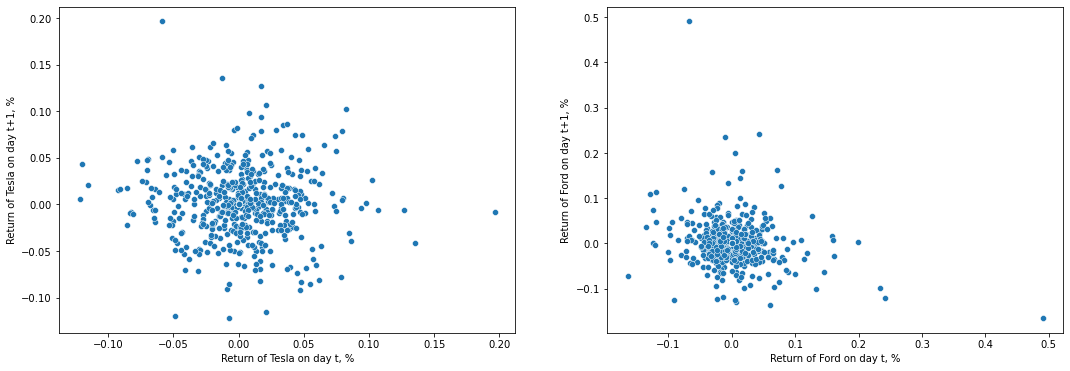

In [11]:
fig = plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.scatterplot(x='Return of Tesla on day t, %', y='Return of Tesla on day t+1, %', data=d_ret_tesla, ci = None)

plt.subplot(1,2,2)
sns.scatterplot(x='Return of Ford on day t, %', y='Return of Ford on day t+1, %', data=d_ret_ford, ci = None)

plt.show();

In [12]:
# Remove outlier
d_ret_ford = d_ret_ford[d_ret_ford['Return of Ford on day t, %'] < 0.45]
d_ret_ford = d_ret_ford[d_ret_ford['Return of Ford on day t+1, %'] < 0.45]

In [13]:
X_ford = d_ret_ford['Return of Ford on day t, %'] # independant variable
y_ford = d_ret_ford['Return of Ford on day t+1, %'] # dependant variable
X_sm_ford = sm.add_constant(X_ford) # OLS requires the input to have a column of ones
model_ford = sm.OLS(y_ford, X_sm_ford)
results_ford = model_ford.fit()
results_ford.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Return of Ford on day t+1, %   R-squared:                       0.021
Model:                                      OLS   Adj. R-squared:                  0.019
Method:                           Least Squares   F-statistic:                     15.24
Date:                          Tue, 27 Sep 2022   Prob (F-statistic):           0.000104
Time:                                  12:11:50   Log-Likelihood:                 1368.5
No. Observations:                           725   AIC:                            -2733.
Df Residuals:                               723   BIC:                            -2724.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0003      0.001      0.187      0.852      -0.002       0.003
Return of Ford on day t, %    -0.1421      0.036     -3.903      0.000      -0.214      -0.071
==============================================================================
Omnibus:                      251.151   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2547.907
Skew:                           1.253   Prob(JB):                         0.00
Kurtosis:                      11.835   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Return of Ford on day t, %', ylabel='Return of Ford on day t+1, %'>

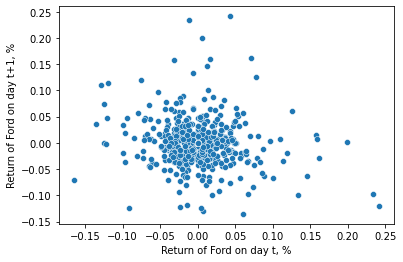

In [14]:
sns.scatterplot(x='Return of Ford on day t, %', y='Return of Ford on day t+1, %', data=d_ret_ford, ci = None)